In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")


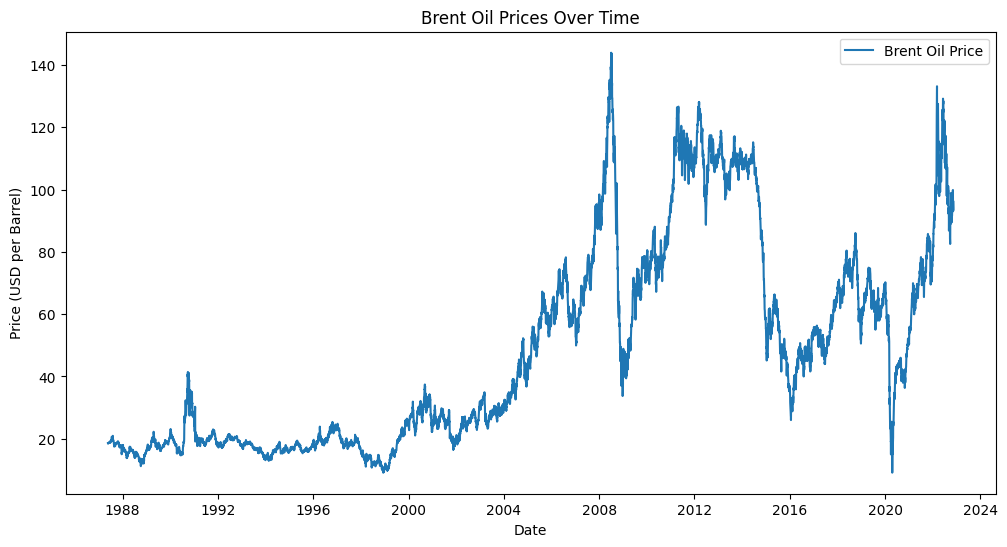

In [2]:
df = pd.read_csv('../data/BrentOilPrices.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.set_index('Date', inplace=True)
df.dropna(inplace=True)

# Ensure 'Price' column is float
df['Price'] = df['Price'].astype(float)

# Visualize Data
plt.figure(figsize=(12, 6))
plt.plot(df['Price'], label='Brent Oil Price')
plt.title('Brent Oil Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD per Barrel)')
plt.legend()
plt.show()


### Vector Autoregression (VAR) Model for Multivariate Analysis

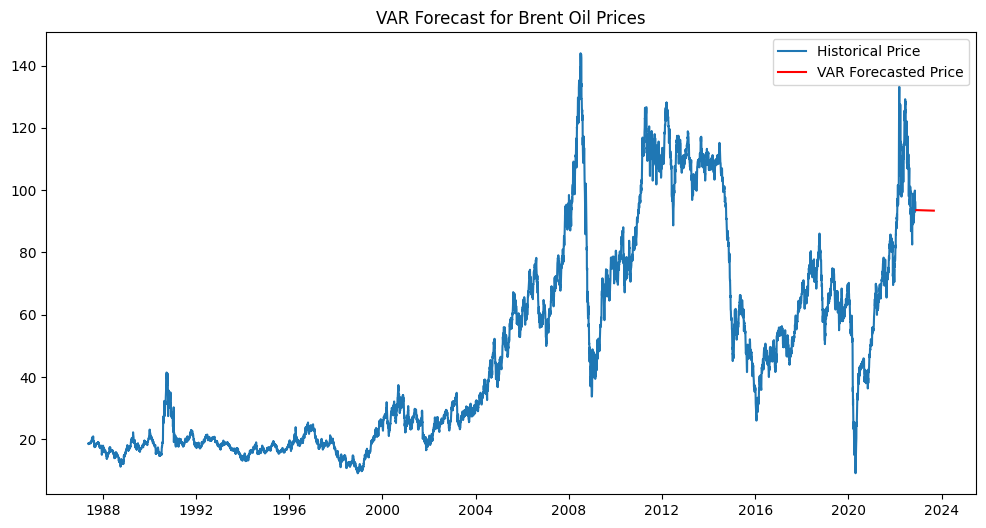

In [3]:
# Mock additional factors data
np.random.seed(42)
df['GDP'] = np.random.normal(loc=2.0, scale=0.5, size=len(df))  # hypothetical GDP growth rate
df['Inflation'] = np.random.normal(loc=1.5, scale=0.2, size=len(df))  # hypothetical inflation rate
df['Unemployment'] = np.random.normal(loc=5.0, scale=1.0, size=len(df))  # hypothetical unemployment rate

# Select relevant columns for VAR
var_data = df[['Price', 'GDP', 'Inflation', 'Unemployment']]
model = VAR(var_data)
var_result = model.fit(maxlags=15, ic='aic')

# Forecasting with VAR
forecast = var_result.forecast(var_data.values[-var_result.k_ar:], steps=10)
forecast_df = pd.DataFrame(forecast, index=pd.date_range(df.index[-1], periods=10, freq='M'), columns=var_data.columns)

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Price'], label='Historical Price')
plt.plot(forecast_df['Price'], label='VAR Forecasted Price', color='red')
plt.title('VAR Forecast for Brent Oil Prices')
plt.legend()
plt.show()


### Markov-Switching ARIMA for Regime-Switching

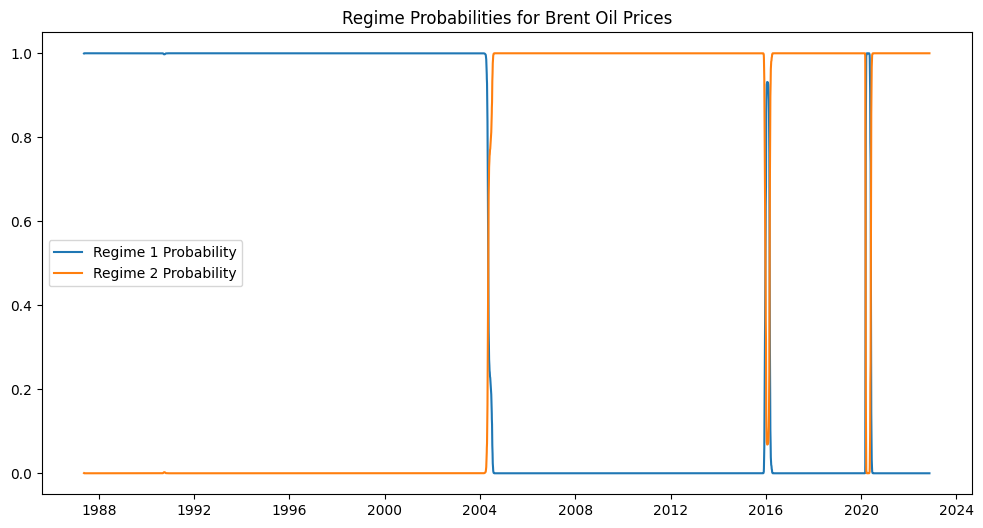

In [4]:
# Fit a Markov Switching Model on Brent Oil Prices
markov_model = MarkovRegression(df['Price'], k_regimes=2, trend='n', switching_variance=True)
markov_result = markov_model.fit()

# Plotting the Regime-Switching probabilities
plt.figure(figsize=(12, 6))
plt.plot(markov_result.smoothed_marginal_probabilities[0], label='Regime 1 Probability')
plt.plot(markov_result.smoothed_marginal_probabilities[1], label='Regime 2 Probability')
plt.title('Regime Probabilities for Brent Oil Prices')
plt.legend()
plt.show()


### LSTM Model for Time Series Forecasting

Epoch 1/20
8980/8980 - 38s - 4ms/step - loss: 3.1239e-04
Epoch 2/20
8980/8980 - 39s - 4ms/step - loss: 1.4541e-04
Epoch 3/20
8980/8980 - 36s - 4ms/step - loss: 1.3329e-04
Epoch 4/20
8980/8980 - 35s - 4ms/step - loss: 1.2709e-04
Epoch 5/20
8980/8980 - 35s - 4ms/step - loss: 1.1941e-04
Epoch 6/20
8980/8980 - 35s - 4ms/step - loss: 1.1555e-04
Epoch 7/20
8980/8980 - 35s - 4ms/step - loss: 1.1520e-04
Epoch 8/20
8980/8980 - 35s - 4ms/step - loss: 1.1173e-04
Epoch 9/20
8980/8980 - 35s - 4ms/step - loss: 1.1005e-04
Epoch 10/20
8980/8980 - 36s - 4ms/step - loss: 1.1022e-04
Epoch 11/20
8980/8980 - 35s - 4ms/step - loss: 1.0918e-04
Epoch 12/20
8980/8980 - 37s - 4ms/step - loss: 1.0599e-04
Epoch 13/20
8980/8980 - 36s - 4ms/step - loss: 1.0660e-04
Epoch 14/20
8980/8980 - 36s - 4ms/step - loss: 1.0479e-04
Epoch 15/20
8980/8980 - 36s - 4ms/step - loss: 1.0287e-04
Epoch 16/20
8980/8980 - 36s - 4ms/step - loss: 1.0489e-04
Epoch 17/20
8980/8980 - 36s - 4ms/step - loss: 1.0383e-04
Epoch 18/20
8980/8980 -

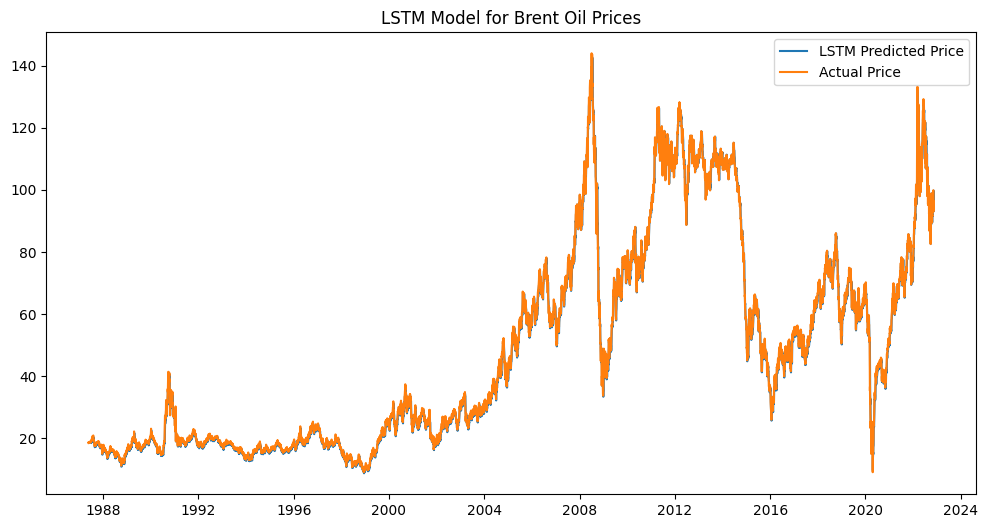

In [5]:
# Normalize the Price data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Price']])

# Prepare the dataset for LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 30
X, y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=20, batch_size=1, verbose=2)

# Predict using LSTM
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

# Plotting LSTM results
plt.figure(figsize=(12, 6))
plt.plot(df.index[look_back + 1:], predictions, label='LSTM Predicted Price')
plt.plot(df['Price'], label='Actual Price')
plt.title('LSTM Model for Brent Oil Prices')
plt.legend()
plt.show()


### Exploring Economic, Technological, and Political Factors

In [6]:
# Calculate correlation
gdp_corr = df['Price'].corr(df['GDP'])
print(f"Correlation between GDP growth rate and oil prices: {gdp_corr}")


Correlation between GDP growth rate and oil prices: -0.01865756425503499


In [7]:
inflation_corr = df['Price'].corr(df['Inflation'])
print(f"Correlation between inflation rate and oil prices: {inflation_corr}")


Correlation between inflation rate and oil prices: 0.007940614155305694


In [8]:
# Hypothetically adding data and analyzing correlation with price
df['Environmental_Regulations'] = np.random.normal(loc=2.0, scale=0.5, size=len(df))
env_reg_corr = df['Price'].corr(df['Environmental_Regulations'])
print(f"Correlation between environmental regulations index and oil prices: {env_reg_corr}")


Correlation between environmental regulations index and oil prices: 0.009733244818864104


In [9]:
pip install wbdata


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


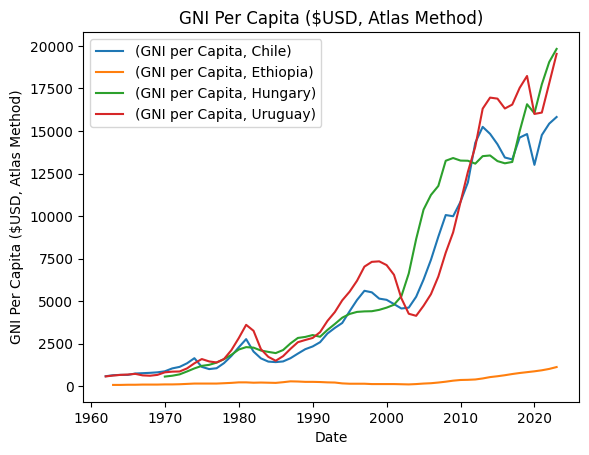

In [10]:
import wbdata
import pandas
import matplotlib.pyplot as plt

# Set up the countries
countries = ["CL", "UY", "HU", "ET"]

# Set up the indicator
indicators = {'NY.GNP.PCAP.CD': 'GNI per Capita'}

# Retrieve the data without 'convert_date'
df = wbdata.get_dataframe(indicators, country=countries)

# Unstack the DataFrame for plotting
dfu = df.unstack(level=0)

# Plot with labels and a title
dfu.plot()
plt.legend(loc='best')
plt.title("GNI Per Capita ($USD, Atlas Method)")
plt.xlabel('Date')
plt.ylabel('GNI Per Capita ($USD, Atlas Method)')
plt.show()


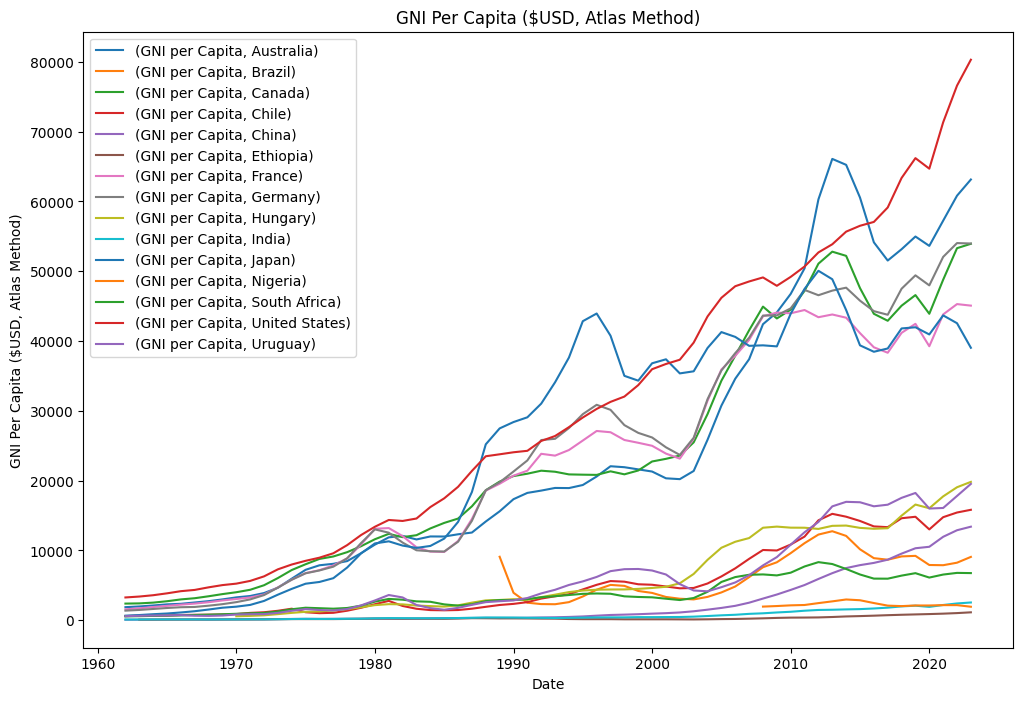

In [11]:
import wbdata
import pandas
import matplotlib.pyplot as plt

# Add more countries to the list
countries = ["CL", "UY", "HU", "ET", "US", "CA", "FR", "DE", "IN", "CN", "BR", "ZA", "JP", "AU", "NG"]

# Define the indicator for GNI per Capita
indicators = {'NY.GNP.PCAP.CD': 'GNI per Capita'}

# Retrieve the data for the countries specified
df = wbdata.get_dataframe(indicators, country=countries)

# Unstack the DataFrame for plotting
dfu = df.unstack(level=0)

# Plot with labels and a title
dfu.plot(figsize=(12, 8))  # Enlarged plot for better readability with more countries
plt.legend(loc='best')
plt.title("GNI Per Capita ($USD, Atlas Method)")
plt.xlabel('Date')
plt.ylabel('GNI Per Capita ($USD, Atlas Method)')
plt.show()


In [12]:
!pip install wbgapi


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


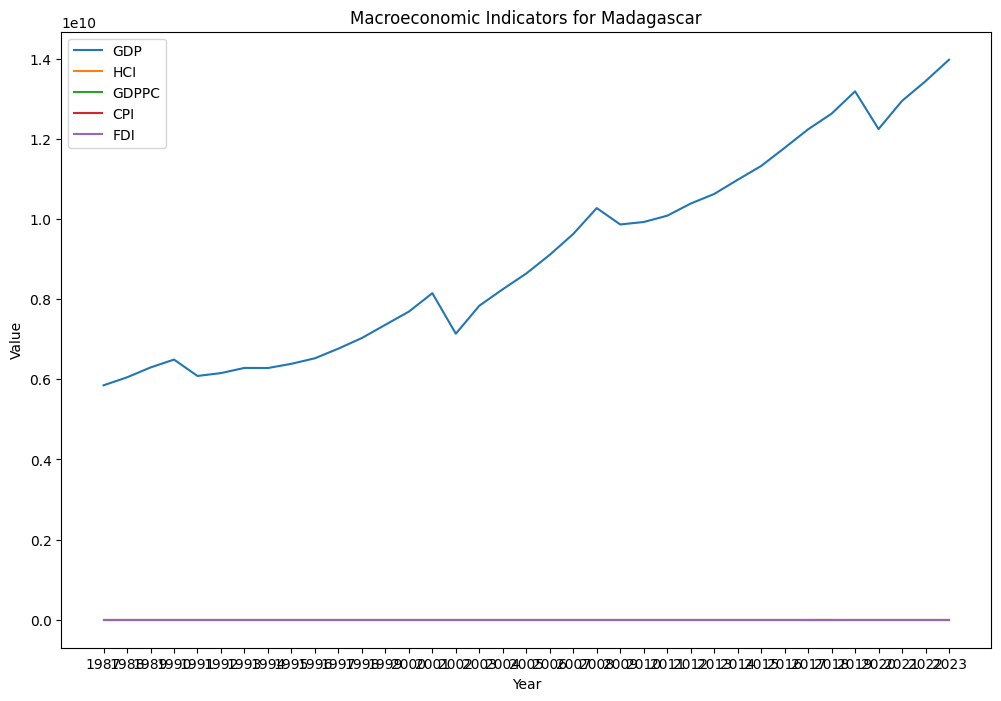

Macroeconomic Data with Growth Rates:
      Time           GDP     GDP_G       GDPPC   GDPPC_G       HCI       CPI  \
time                                                                           
2014  2014  1.097912e+10  3.339203  453.383414  0.659691       NaN  6.080408   
2015  2015  1.132302e+10  3.132298  455.638035  0.497288       NaN  7.404192   
2016  2016  1.177517e+10  3.993146  461.736048  1.338346       NaN  6.035759   
2017  2017  1.223832e+10  3.933308  467.655068  1.281905  0.374000  8.609051   
2018  2018  1.262925e+10  3.194357  470.423898  0.592067  0.385493  8.594230   
2019  2019  1.318636e+10  4.411232  478.926961  1.807532       NaN  5.610514   
2020  2020  1.224516e+10 -7.137672  433.838240 -9.414530  0.391991  4.201793   
2021  2021  1.294799e+10  5.739616  447.784676  3.214663       NaN  5.812251   
2022  2022  1.343952e+10  3.796199  453.858147  1.356337       NaN  8.160590   
2023  2023  1.397513e+10  3.985371  460.834129  1.537040       NaN  9.874327   

 

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import wbgapi as wb

# Define macroeconomic indicators
GDP = 'NY.GDP.MKTP.KD'       # GDP in constant 2015 $US
HCI = 'HD.HCI.OVRL'          # Human Capital Index
GDPPC = 'NY.GDP.PCAP.KD'     # GDP per capita in constant 2015 $US
CPI = 'FP.CPI.TOTL.ZG'       # Inflation rate
FDI = 'BX.KLT.DINV.WD.GD.ZS' # Foreign Direct Investment as a share of GDP

# Retrieve data from the World Bank API for Madagascar (MDG) from 1987 to 2023
Table_1 = wb.data.DataFrame([GDP, HCI, GDPPC, CPI, FDI], 'MDG', time=range(1987, 2024), numericTimeKeys=True, labels=True, columns='series')

# Convert to DataFrame and rename columns for clarity
Table_1 = pd.DataFrame(Table_1)
Table_1.rename(columns={
    'NY.GDP.MKTP.KD': 'GDP',
    'HD.HCI.OVRL': 'HCI',
    'NY.GDP.PCAP.KD': 'GDPPC',
    'FP.CPI.TOTL.ZG': 'CPI',
    'BX.KLT.DINV.WD.GD.ZS': 'FDI'
}, inplace=True)

# Sort by time for correct plotting sequence
Table_1 = Table_1.sort_values(by=['Time'], ascending=True)

# Calculate growth rates for GDP and GDP per capita
for i in ['GDP', 'GDPPC']:
    Table_1[i + '_G'] = Table_1[i].pct_change().mul(100)

# Plot each macroeconomic factor over time
plt.figure(figsize=(12, 8))
for column in ['GDP', 'HCI', 'GDPPC', 'CPI', 'FDI']:
    plt.plot(Table_1['Time'], Table_1[column], label=column)
    
plt.title('Macroeconomic Indicators for Madagascar')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.show()

# Display the table with growth rates
print("Macroeconomic Data with Growth Rates:")
print(Table_1[['Time', 'GDP', 'GDP_G', 'GDPPC', 'GDPPC_G', 'HCI', 'CPI', 'FDI']].tail(10))  # Display the last 10 records


Table of Macroeconomic Factors with Growth Rates:

      Time           GDP      GDP_G       GDPPC   GDPPC_G  HCI        CPI  \
time                                                                        
1987  1987  5.849641e+09        NaN  537.131781       NaN  NaN  14.993135   
1991  1991  6.082965e+09   3.988693  496.760822 -7.516025  NaN   8.592648   
1995  1995  6.386838e+09   4.995463  460.507184 -7.298007  NaN  49.080210   
1999  1999  7.360783e+09  15.249258  467.919193  1.609532  NaN   9.929534   
2003  2003  7.835975e+09   6.455722  442.103230 -5.517184  NaN  -1.704005   
2007  2007  9.626649e+09  22.851969  483.145271  9.283362  NaN  10.287966   
2011  2011  1.008187e+10   4.728743  451.127505 -6.626944  NaN   9.482540   
2015  2015  1.132302e+10  12.310733  455.638035  0.999835  NaN   7.404192   
2019  2019  1.318636e+10  16.456205  478.926961  5.111278  NaN   5.610514   
2023  2023  1.397513e+10   5.981727  460.834129 -3.777785  NaN   9.874327   

           FDI  
time   

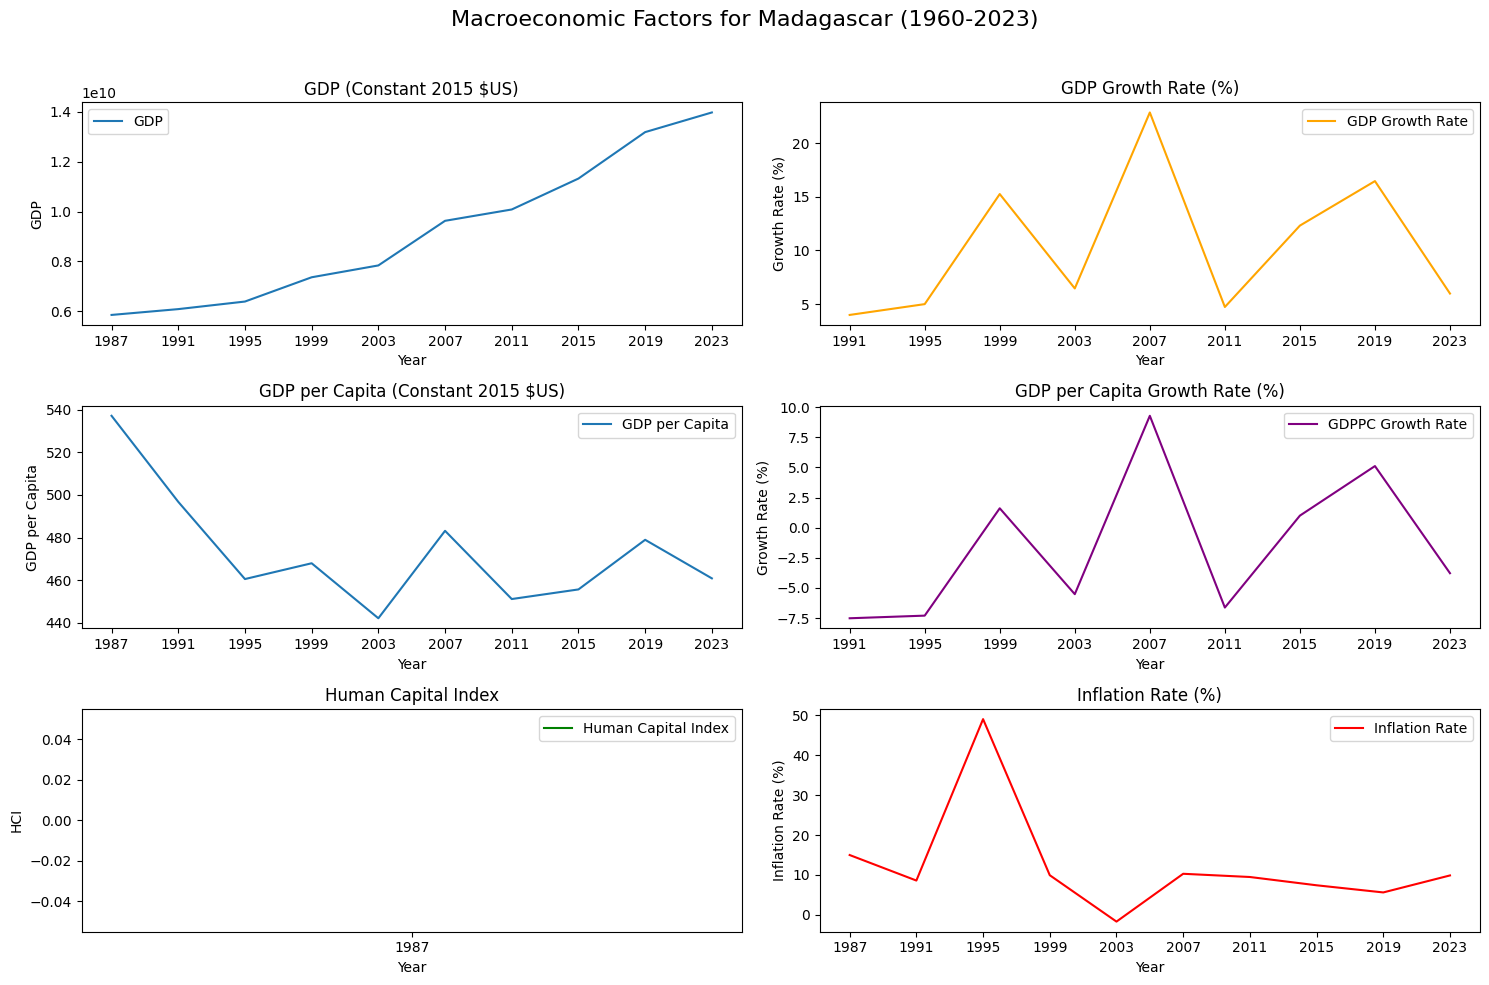

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wbgapi as wb

# Define macroeconomic indicators
GDP = 'NY.GDP.MKTP.KD'       # GDP in constant 2015 $US
HCI = 'HD.HCI.OVRL'          # Human Capital Index
GDPPC = 'NY.GDP.PCAP.KD'     # GDP per capita in constant 2015 $US
CPI = 'FP.CPI.TOTL.ZG'       # Inflation rate
FDI = 'BX.KLT.DINV.WD.GD.ZS' # Foreign Direct Investment as a share of GDP

# Fetch data for Madagascar (MDG) from 1960 to 2023
Table_1 = wb.data.DataFrame([GDP, HCI, GDPPC, CPI, FDI], 'MDG', time=range(1987, 2024,4), numericTimeKeys=True, labels=True, columns='series')
Table_1 = pd.DataFrame(Table_1)

# Rename columns for readability
Table_1.rename(columns={
    'NY.GDP.MKTP.KD': 'GDP',
    'HD.HCI.OVRL': 'HCI',
    'NY.GDP.PCAP.KD': 'GDPPC',
    'FP.CPI.TOTL.ZG': 'CPI',
    'BX.KLT.DINV.WD.GD.ZS': 'FDI'
}, inplace=True)

# Sort by time for consistent plotting
Table_1 = Table_1.sort_values(by=['Time'], ascending=True)

# Calculate the annual growth rate for GDP and GDPPC
for col in ['GDP', 'GDPPC']:
    Table_1[col + '_G'] = Table_1[col].pct_change().mul(100)

# Display the data table with growth rates
print("Table of Macroeconomic Factors with Growth Rates:\n")
print(Table_1[['Time', 'GDP', 'GDP_G', 'GDPPC', 'GDPPC_G', 'HCI', 'CPI', 'FDI']])

# Plotting time series for each macroeconomic factor
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Macroeconomic Factors for Madagascar (1960-2023)', fontsize=16)

# GDP and GDP Growth Rate
ax[0, 0].plot(Table_1['Time'], Table_1['GDP'], label='GDP')
ax[0, 0].set_title('GDP (Constant 2015 $US)')
ax[0, 0].set_xlabel('Year')
ax[0, 0].set_ylabel('GDP')
ax[0, 0].legend()

ax[0, 1].plot(Table_1['Time'], Table_1['GDP_G'], label='GDP Growth Rate', color='orange')
ax[0, 1].set_title('GDP Growth Rate (%)')
ax[0, 1].set_xlabel('Year')
ax[0, 1].set_ylabel('Growth Rate (%)')
ax[0, 1].legend()

# GDP per Capita and GDPPC Growth Rate
ax[1, 0].plot(Table_1['Time'], Table_1['GDPPC'], label='GDP per Capita')
ax[1, 0].set_title('GDP per Capita (Constant 2015 $US)')
ax[1, 0].set_xlabel('Year')
ax[1, 0].set_ylabel('GDP per Capita')
ax[1, 0].legend()

ax[1, 1].plot(Table_1['Time'], Table_1['GDPPC_G'], label='GDPPC Growth Rate', color='purple')
ax[1, 1].set_title('GDP per Capita Growth Rate (%)')
ax[1, 1].set_xlabel('Year')
ax[1, 1].set_ylabel('Growth Rate (%)')
ax[1, 1].legend()

# Human Capital Index (HCI)
ax[2, 0].plot(Table_1['Time'], Table_1['HCI'], label='Human Capital Index', color='green')
ax[2, 0].set_title('Human Capital Index')
ax[2, 0].set_xlabel('Year')
ax[2, 0].set_ylabel('HCI')
ax[2, 0].legend()

# Inflation Rate (CPI)
ax[2, 1].plot(Table_1['Time'], Table_1['CPI'], label='Inflation Rate', color='red')
ax[2, 1].set_title('Inflation Rate (%)')
ax[2, 1].set_xlabel('Year')
ax[2, 1].set_ylabel('Inflation Rate (%)')
ax[2, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit main title
plt.show()


In [15]:
pip install plotly

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:

import pandas as pd 
import requests 
import json 
import plotly.graph_objects as go

In [17]:
def checkindicator(url):
    r= requests.get(url)
    r = r.json()
    periods = r['series']['docs'][0]['period']
    values = r['series']['docs'][0]['value']
    dataset = r['series']['docs'][0]['dataset_name']
    indicators = pd.DataFrame(values,index=periods)
    indicators.columns = [dataset]
    return indicators

In [18]:
import requests

def checkindicator(url):
    r = requests.get(url)
    print(r.json())  # Print the entire JSON response
    return r.json()

# Test the URL
euro_yields_10y = checkindicator('https://api.db.nomics.world/v22/series/Eurostat/irt_euryld_m/M.EA.INS_FWD.CGB_EA.Y10?observations=1')


{'_meta': {'args': {'align_periods': False, 'dataset_code': 'irt_euryld_m', 'dimensions': {}, 'facets': False, 'format': 'json', 'limit': 1000, 'metadata': True, 'observations': True, 'offset': 0, 'provider_code': 'Eurostat', 'q': '', 'series_code': 'M.EA.INS_FWD.CGB_EA.Y10'}, 'version': '22.1.17'}, 'message': "Series 'Eurostat/irt_euryld_m/M.EA.INS_FWD.CGB_EA.Y10' not found"}


In [25]:
import wbdata
import pandas as pd
import datetime
# Define the indicator for GDP growth (annual %)
indicators = {'NY.GDP.MKTP.KD.ZG': 'GDP growth (annual %)'}
# Set the date range
start_date = datetime.datetime(1987, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
# Retrieve GDP growth data for the world
gdp_growth_data = wbdata.get_dataframe(indicators, country='WLD', date=(start_date, end_date), freq='Y')
# Display the GDP growth data
print(gdp_growth_data)
# Save to CSV
gdp_growth_data.to_csv('../data/world_gdp_growth_data.csv')

      GDP growth (annual %)
date                       
2022               3.089607
2021               6.259851
2020              -2.932043
2019               2.642216
2018               3.286613
2017               3.460239
2016               2.820557
2015               3.126136
2014               3.123870
2013               2.868222
2012               2.709115
2011               3.327133
2010               4.529546
2009              -1.355782
2008               2.062496
2007               4.373277
2006               4.442793
2005               4.005866
2004               4.469259
2003               3.104276
2002               2.302837
2001               2.025403
2000               4.531095
1999               3.549717
1998               2.853925
1997               3.929714
1996               3.574686
1995               3.084615
1994               3.323942
1993               1.812976
1992               2.019257
1991               1.255826
1990               2.764541
1989               3

In [20]:
import wbdata

# Define indicators for inflation and unemployment
indicators = {
    'FP.CPI.TOTL.ZG': 'Inflation (annual %)',
    'SL.UEM.TOTL.NE.ZS': 'Unemployment rate (%)'
}

# Retrieve data for the world from 1987 to 2022
inflation_unemployment_data = wbdata.get_dataframe(indicators, country='WLD', date=(start_date, end_date), freq='Y')
print(inflation_unemployment_data)
inflation_unemployment_data.to_csv('inflation_unemployment_data.csv')


      Inflation (annual %)  Unemployment rate (%)
date                                             
2022              7.967574                    NaN
2021              3.466926               6.190663
2020              1.920968               6.708983
2019              2.206073               5.864570
2018              2.450362               5.979186
2017              2.254277               5.610091
2016              1.605539                    NaN
2015              1.443857                    NaN
2014              2.354491               5.608396
2013              2.651673               5.650834
2012              3.725327               5.438778
2011              4.822396               5.919774
2010              3.326345               5.481055
2009              2.860449               6.337759
2008              8.949953                    NaN
2007              4.810237                    NaN
2006              4.267175                    NaN
2005              4.107251               5.789235


In [21]:
from pandas_datareader import data as pdr
import datetime

# Define start and end dates
start_date = datetime.datetime(1987, 1, 1)
end_date = datetime.datetime(2022, 12, 31)

# Get USD to EUR exchange rate from FRED (code: DEXUSEU)
usd_eur_exchange = pdr.get_data_fred('DEXUSEU', start=start_date, end=end_date)

# Display and save to CSV
print(usd_eur_exchange)
usd_eur_exchange.to_csv('usd_eur_exchange_rate_fred.csv')


            DEXUSEU
DATE               
1999-01-04   1.1812
1999-01-05   1.1760
1999-01-06   1.1636
1999-01-07   1.1672
1999-01-08   1.1554
...             ...
2022-12-26      NaN
2022-12-27   1.0654
2022-12-28   1.0622
2022-12-29   1.0668
2022-12-30   1.0698

[6260 rows x 1 columns]


In [22]:
import requests
import pandas as pd

# Alpha Vantage API key
api_key = 'your_alpha_vantage_api_key'

# API URL for USD to EUR exchange rate
url = f'https://www.alphavantage.co/query?function=FX_DAILY&from_symbol=USD&to_symbol=EUR&apikey={api_key}&outputsize=full'

response = requests.get(url)
data = response.json()

# Convert JSON data to DataFrame
exchange_rates = pd.DataFrame.from_dict(data['Time Series FX (Daily)'], orient='index')
exchange_rates = exchange_rates.rename(columns={'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close'})
exchange_rates.index = pd.to_datetime(exchange_rates.index)

# Display and save to CSV
print(exchange_rates)
exchange_rates.to_csv('usd_eur_exchange_rates_alpha_vantage.csv')


               Open     High      Low    Close
2024-11-15  0.94950  0.95000  0.94800  0.94850
2024-11-14  0.94940  0.95000  0.94840  0.94860
2024-11-13  0.94660  0.95245  0.94510  0.94660
2024-11-12  0.94191  0.94699  0.93905  0.94191
2024-11-11  0.93770  0.94366  0.93778  0.93770
...             ...      ...      ...      ...
2014-11-20  0.79722  0.80600  0.79572  0.79713
2014-11-19  0.79726  0.79956  0.79521  0.79740
2014-11-18  0.79783  0.79911  0.79548  0.79787
2014-11-17  0.80314  0.80314  0.79772  0.80328
2014-11-16  0.79863  0.80332  0.79517  0.79882

[2608 rows x 4 columns]


In [ ]:
df = pd.read_csv('/kaggle/input/kaim-w10/Brent_Oil_Prices.csv')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.head()

In [ ]:
inflation = pd.read_csv('/kaggle/working/inflation_unemployment_data.csv')
exchange_rate_fred = pd.read_csv('/kaggle/working/usd_eur_exchange_rate_fred.csv')
exchange_rate_vintage = pd.read_csv('/kaggle/working/usd_eur_exchange_rates_alpha_vantage.csv')

In [ ]:
inflation.columns, exchange_rate_fred.columns, exchange_rate_vintage.columns

(Index(['date', 'Inflation (annual %)', 'Unemployment rate (%)'], dtype='object'),
 Index(['DATE', 'DEXUSEU'], dtype='object'),
 Index(['Unnamed: 0', 'Open', 'High', 'Low', 'Close'], dtype='object'))

In [ ]:
inflation = inflation.rename(columns={'date': 'Date'})
exchange_rate_fred = exchange_rate_fred.rename(columns={'DATE': 'Date'})
exchange_rate_vintage = exchange_rate_vintage.rename(columns={'Unnamed: 0': 'Date'})

In [ ]:
df.columns, inflation.columns, exchange_rate_fred.columns, exchange_rate_vintage.columns

(Index(['Unnamed: 0', 'Date', 'Price'], dtype='object'),
 Index(['Unnamed: 0', 'Date', 'Inflation (annual %)', 'Unemployment rate (%)'], dtype='object'),
 Index(['Unnamed: 0', 'Date', 'DEXUSEU'], dtype='object'),
 Index(['Unnamed: 0', 'Date', 'Open', 'High', 'Low', 'Close'], dtype='object'))

In [ ]:
df.shape, inflation.shape, exchange_rate_fred.shape, exchange_rate_vintage.shape

((9011, 1), (36, 3), (6260, 2), (2608, 5))

In [ ]:
df.to_csv('Brent_Oil_Prices.csv')
inflation.to_csv('/kaggle/working/inflation_unemployment_data.csv')
exchange_rate_fred.to_csv('/kaggle/working/usd_eur_exchange_rate_fred.csv')
exchange_rate_vintage.to_csv('/kaggle/working/usd_eur_exchange_rates_alpha_vantage.csv')

In [ ]:
# Load the datasets
df = pd.read_csv('/kaggle/working/Brent_Oil_Prices.csv')
inflation = pd.read_csv('/kaggle/working/inflation_unemployment_data.csv')
exchange_rate_fred = pd.read_csv('/kaggle/working/usd_eur_exchange_rate_fred.csv')
exchange_rate_vintage = pd.read_csv('/kaggle/working/usd_eur_exchange_rates_alpha_vantage.csv')

df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [ ]:
df =  '/kaggle/working/Brent_Oil_Prices.csv'
inflation = '/kaggle/working/inflation_unemployment_data.csv'
exchange_rate_fred = '/kaggle/working/usd_eur_exchange_rate_fred.csv'
exchange_rate_vintage = '/kaggle/working/usd_eur_exchange_rates_alpha_vantage.csv'

In [ ]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    df = df.drop(['Unnamed: 0'], axis=1)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    return df
    

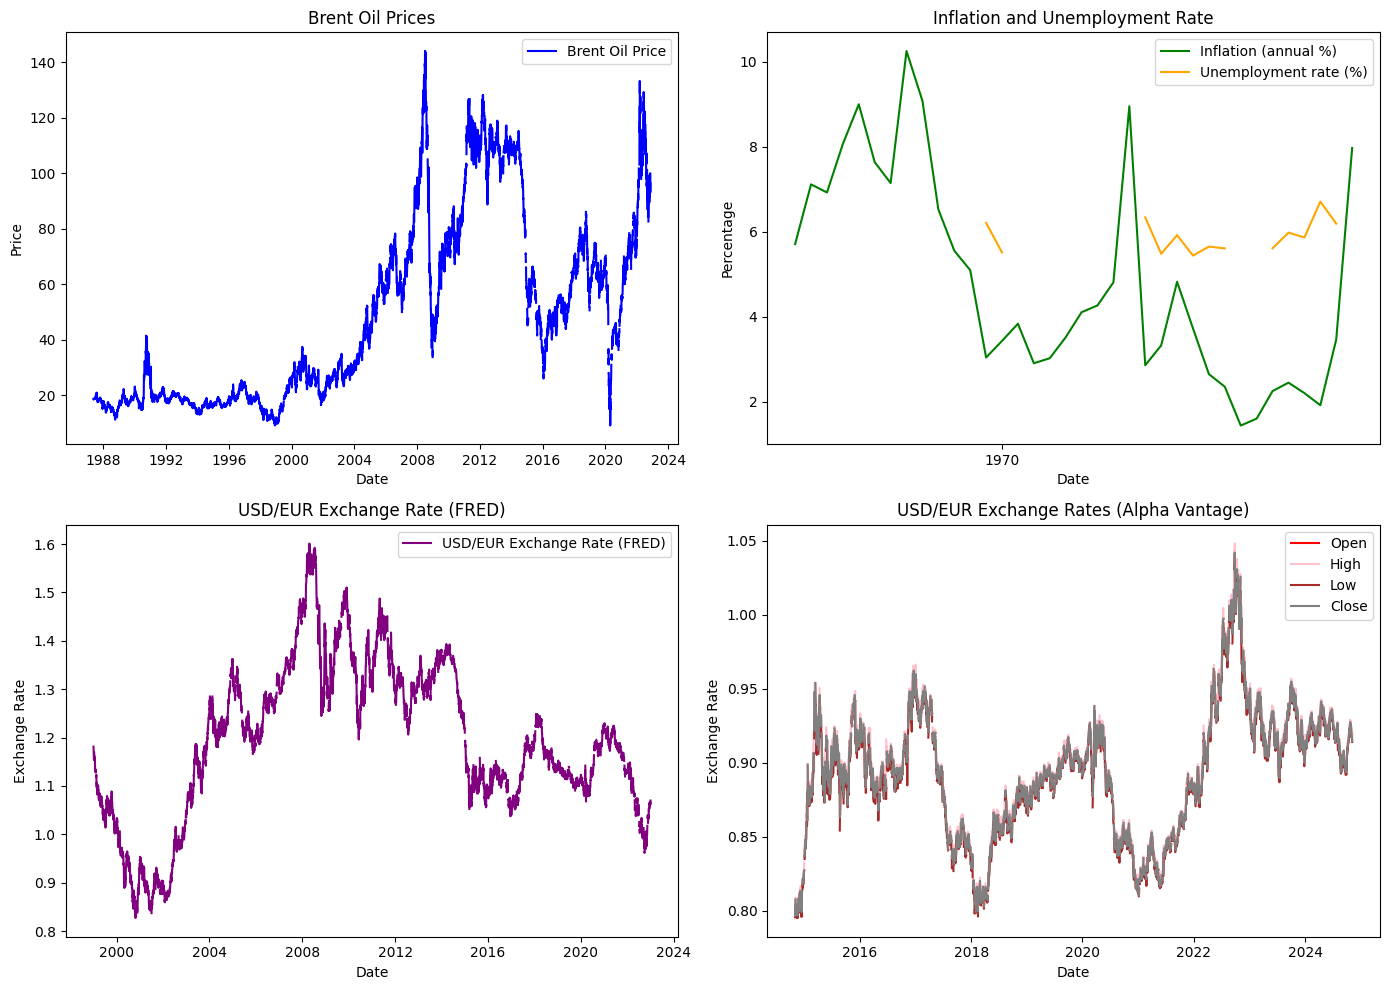

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
df = load_data(df)
inflation = load_data(inflation)
exchange_rate_fred = load_data(exchange_rate_fred)
exchange_rate_vintage =  load_data(exchange_rate_vintage)


# Merge datasets on 'Date' column using an outer join to keep all dates
merged_data = df.merge(inflation, on='Date', how='outer') \
                .merge(exchange_rate_fred, on='Date', how='outer') \
                .merge(exchange_rate_vintage, on='Date', how='outer')

# Sort by 'Date' to ensure data is in chronological order
merged_data = merged_data.sort_values(by='Date')

# Plot each column
plt.figure(figsize=(14, 10))

# Plot Brent Oil Prices
plt.subplot(2, 2, 1)
plt.plot(merged_data['Date'], merged_data['Price'], label='Brent Oil Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Brent Oil Prices')
plt.legend()

# Plot Inflation and Unemployment rate
plt.subplot(2, 2, 2)
plt.plot(merged_data['Date'], merged_data['Inflation (annual %)'], label='Inflation (annual %)', color='green')
plt.plot(merged_data['Date'], merged_data['Unemployment rate (%)'], label='Unemployment rate (%)', color='orange')
plt.xlabel('Date')
plt.ylabel('Percentage')
plt.title('Inflation and Unemployment Rate')
plt.legend()

# Plot USD/EUR Exchange Rate (FRED)
plt.subplot(2, 2, 3)
plt.plot(merged_data['Date'], merged_data['DEXUSEU'], label='USD/EUR Exchange Rate (FRED)', color='purple')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('USD/EUR Exchange Rate (FRED)')
plt.legend()

# Plot Exchange Rates (Alpha Vantage)
plt.subplot(2, 2, 4)
plt.plot(merged_data['Date'], merged_data['Open'], label='Open', color='red')
plt.plot(merged_data['Date'], merged_data['High'], label='High', color='pink')
plt.plot(merged_data['Date'], merged_data['Low'], label='Low', color='brown')
plt.plot(merged_data['Date'], merged_data['Close'], label='Close', color='gray')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('USD/EUR Exchange Rates (Alpha Vantage)')
plt.legend()

plt.tight_layout()
plt.show()


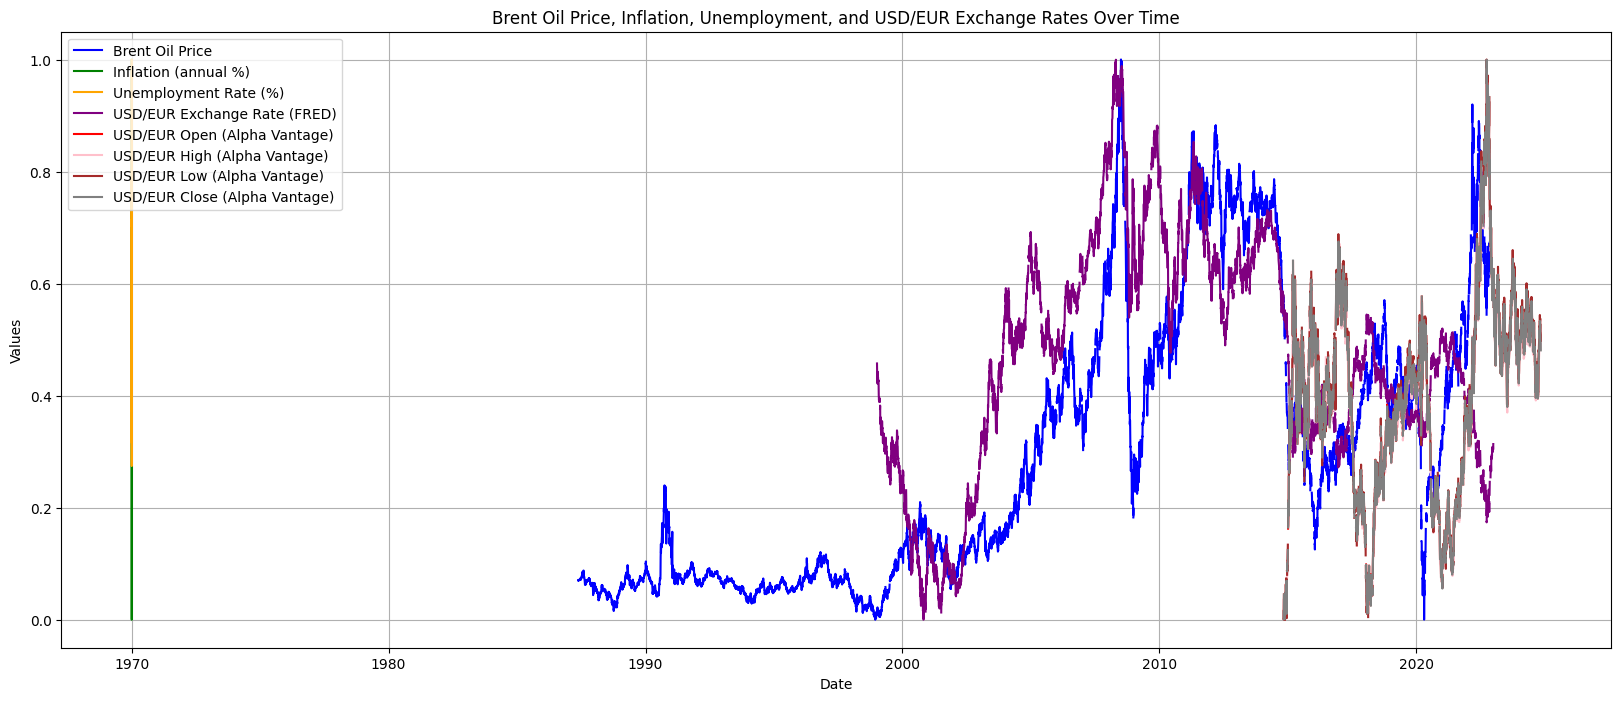

In [ ]:
# Plotting
plt.figure(figsize=(20, 8))

# Plot each column of interest in a single plot with different colors and labels
plt.plot(merged_data['Date'], merged_data['Price'], label='Brent Oil Price', color='blue')
plt.plot(merged_data['Date'], merged_data['Inflation (annual %)'], label='Inflation (annual %)', color='green')
plt.plot(merged_data['Date'], merged_data['Unemployment rate (%)'], label='Unemployment Rate (%)', color='orange')
plt.plot(merged_data['Date'], merged_data['DEXUSEU'], label='USD/EUR Exchange Rate (FRED)', color='purple')
plt.plot(merged_data['Date'], merged_data['Open'], label='USD/EUR Open (Alpha Vantage)', color='red')
plt.plot(merged_data['Date'], merged_data['High'], label='USD/EUR High (Alpha Vantage)', color='pink')
plt.plot(merged_data['Date'], merged_data['Low'], label='USD/EUR Low (Alpha Vantage)', color='brown')
plt.plot(merged_data['Date'], merged_data['Close'], label='USD/EUR Close (Alpha Vantage)', color='gray')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Brent Oil Price, Inflation, Unemployment, and USD/EUR Exchange Rates Over Time')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()

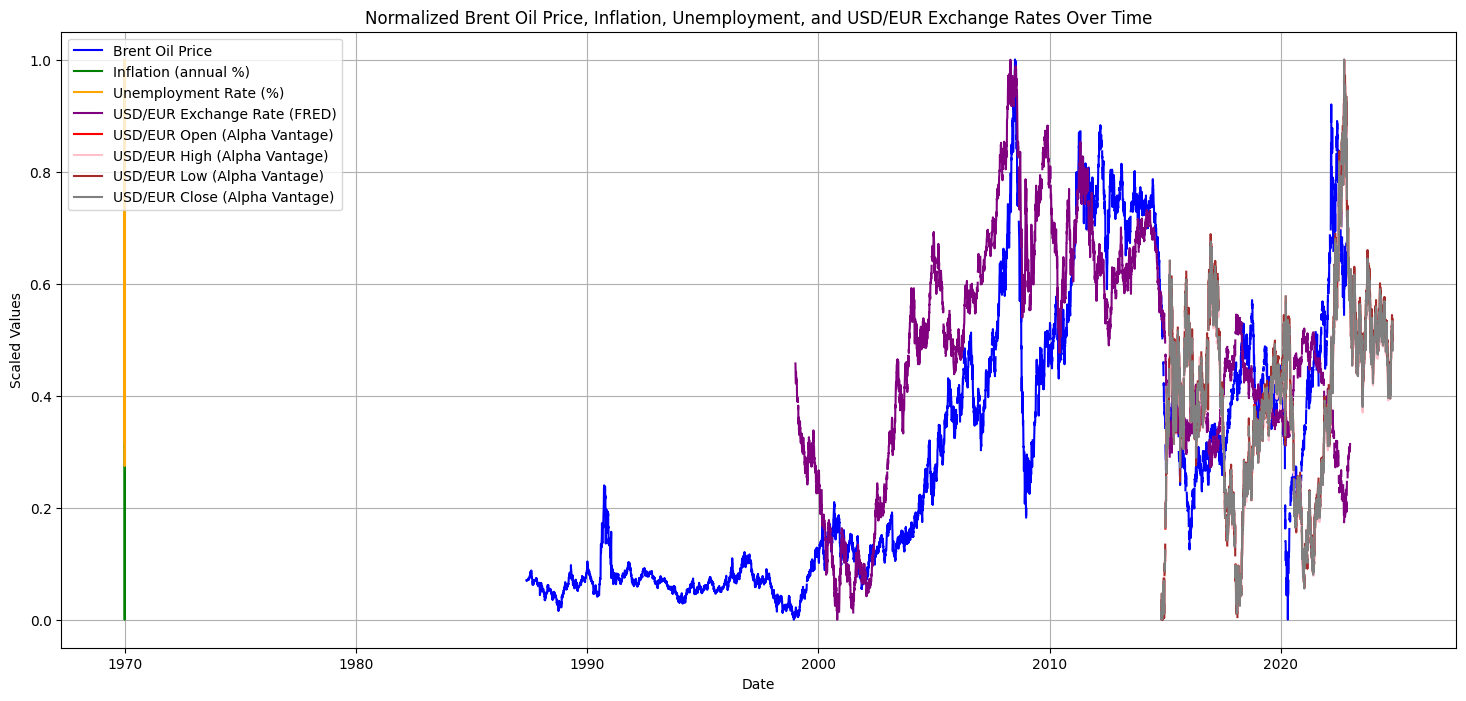

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler
scaler = MinMaxScaler()

# Apply Min-Max Scaling to relevant columns, ignoring the 'Date' column
columns_to_scale = ['Price', 'Inflation (annual %)', 'Unemployment rate (%)', 'DEXUSEU', 'Open', 'High', 'Low', 'Close']
merged_data[columns_to_scale] = scaler.fit_transform(merged_data[columns_to_scale])

# Plotting
plt.figure(figsize=(18, 8))

# Plot each normalized column in a single plot with different colors and labels
plt.plot(merged_data['Date'], merged_data['Price'], label='Brent Oil Price', color='blue')
plt.plot(merged_data['Date'], merged_data['Inflation (annual %)'], label='Inflation (annual %)', color='green')
plt.plot(merged_data['Date'], merged_data['Unemployment rate (%)'], label='Unemployment Rate (%)', color='orange')
plt.plot(merged_data['Date'], merged_data['DEXUSEU'], label='USD/EUR Exchange Rate (FRED)', color='purple')
plt.plot(merged_data['Date'], merged_data['Open'], label='USD/EUR Open (Alpha Vantage)', color='red')
plt.plot(merged_data['Date'], merged_data['High'], label='USD/EUR High (Alpha Vantage)', color='pink')
plt.plot(merged_data['Date'], merged_data['Low'], label='USD/EUR Low (Alpha Vantage)', color='brown')
plt.plot(merged_data['Date'], merged_data['Close'], label='USD/EUR Close (Alpha Vantage)', color='gray')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Scaled Values')
plt.title('Normalized Brent Oil Price, Inflation, Unemployment, and USD/EUR Exchange Rates Over Time')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()

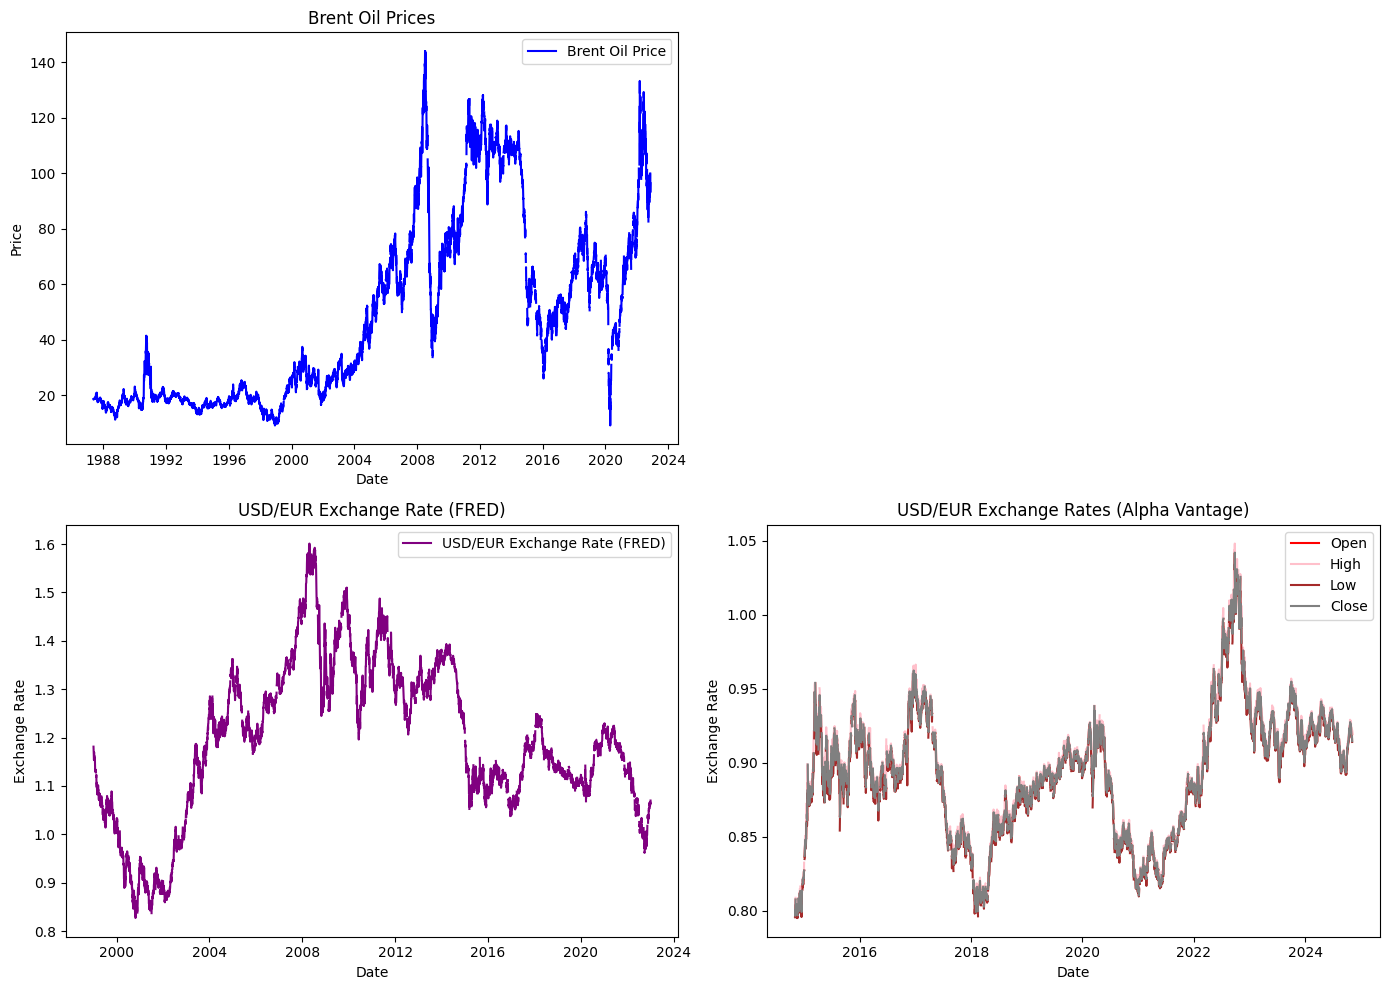

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
df = load_data(df)
exchange_rate_fred = load_data(exchange_rate_fred)
exchange_rate_vintage =  load_data(exchange_rate_vintage)


# Merge datasets on 'Date' column using an outer join to keep all dates
merged_data = df.merge(exchange_rate_fred, on='Date', how='outer') \
                .merge(exchange_rate_vintage, on='Date', how='outer')

# Sort by 'Date' to ensure data is in chronological order
merged_data = merged_data.sort_values(by='Date')

# Plot each column
plt.figure(figsize=(14, 10))

# Plot Brent Oil Prices
plt.subplot(2, 2, 1)
plt.plot(merged_data['Date'], merged_data['Price'], label='Brent Oil Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Brent Oil Prices')
plt.legend()

# Plot USD/EUR Exchange Rate (FRED)
plt.subplot(2, 2, 3)
plt.plot(merged_data['Date'], merged_data['DEXUSEU'], label='USD/EUR Exchange Rate (FRED)', color='purple')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('USD/EUR Exchange Rate (FRED)')
plt.legend()

# Plot Exchange Rates (Alpha Vantage)
plt.subplot(2, 2, 4)
plt.plot(merged_data['Date'], merged_data['Open'], label='Open', color='red')
plt.plot(merged_data['Date'], merged_data['High'], label='High', color='pink')
plt.plot(merged_data['Date'], merged_data['Low'], label='Low', color='brown')
plt.plot(merged_data['Date'], merged_data['Close'], label='Close', color='gray')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.title('USD/EUR Exchange Rates (Alpha Vantage)')
plt.legend()

plt.tight_layout()
plt.show()


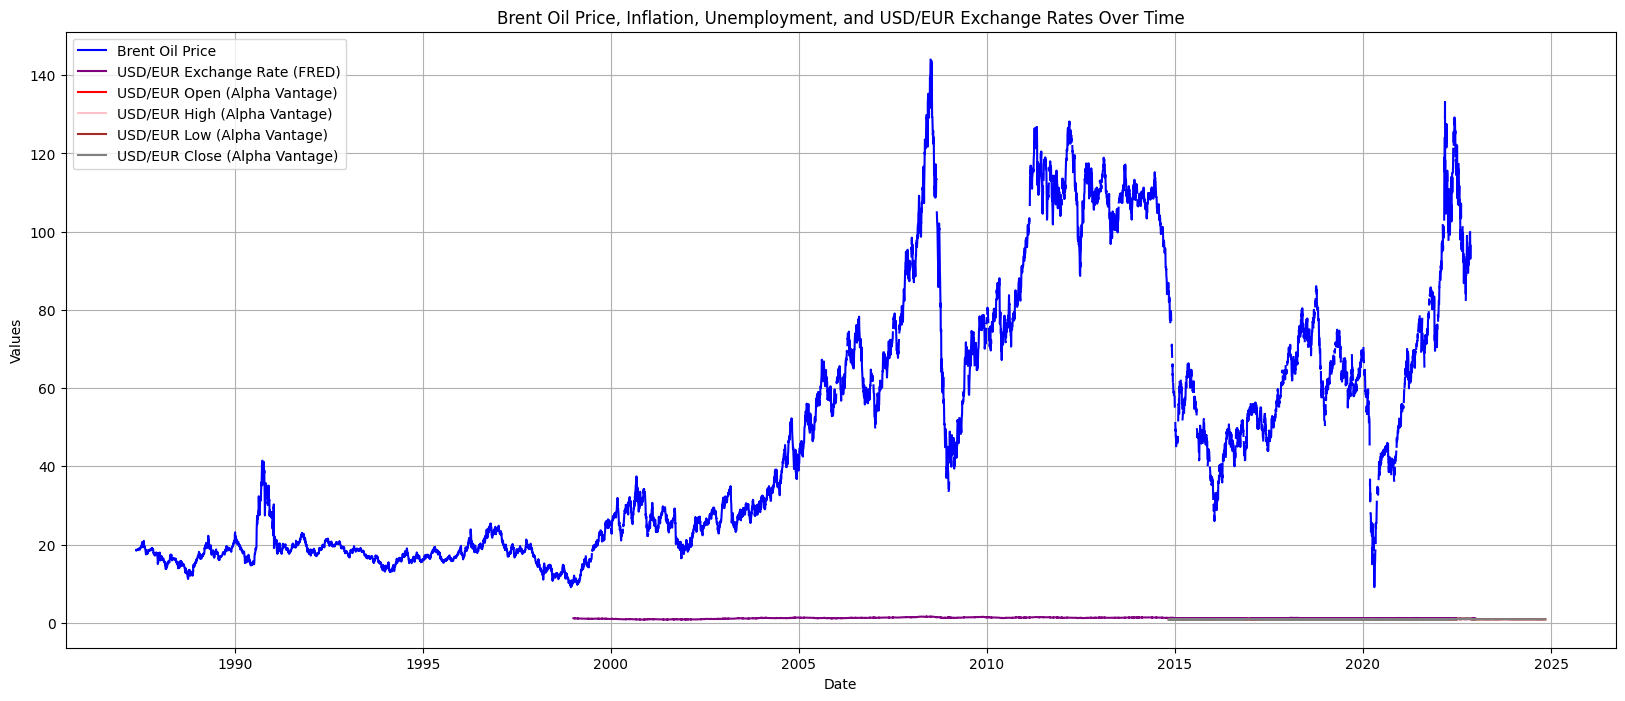

In [ ]:
# Plotting
plt.figure(figsize=(20, 8))

# Plot each column of interest in a single plot with different colors and labels
plt.plot(merged_data['Date'], merged_data['Price'], label='Brent Oil Price', color='blue')
plt.plot(merged_data['Date'], merged_data['DEXUSEU'], label='USD/EUR Exchange Rate (FRED)', color='purple')
plt.plot(merged_data['Date'], merged_data['Open'], label='USD/EUR Open (Alpha Vantage)', color='red')
plt.plot(merged_data['Date'], merged_data['High'], label='USD/EUR High (Alpha Vantage)', color='pink')
plt.plot(merged_data['Date'], merged_data['Low'], label='USD/EUR Low (Alpha Vantage)', color='brown')
plt.plot(merged_data['Date'], merged_data['Close'], label='USD/EUR Close (Alpha Vantage)', color='gray')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Brent Oil Price, Inflation, Unemployment, and USD/EUR Exchange Rates Over Time')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()

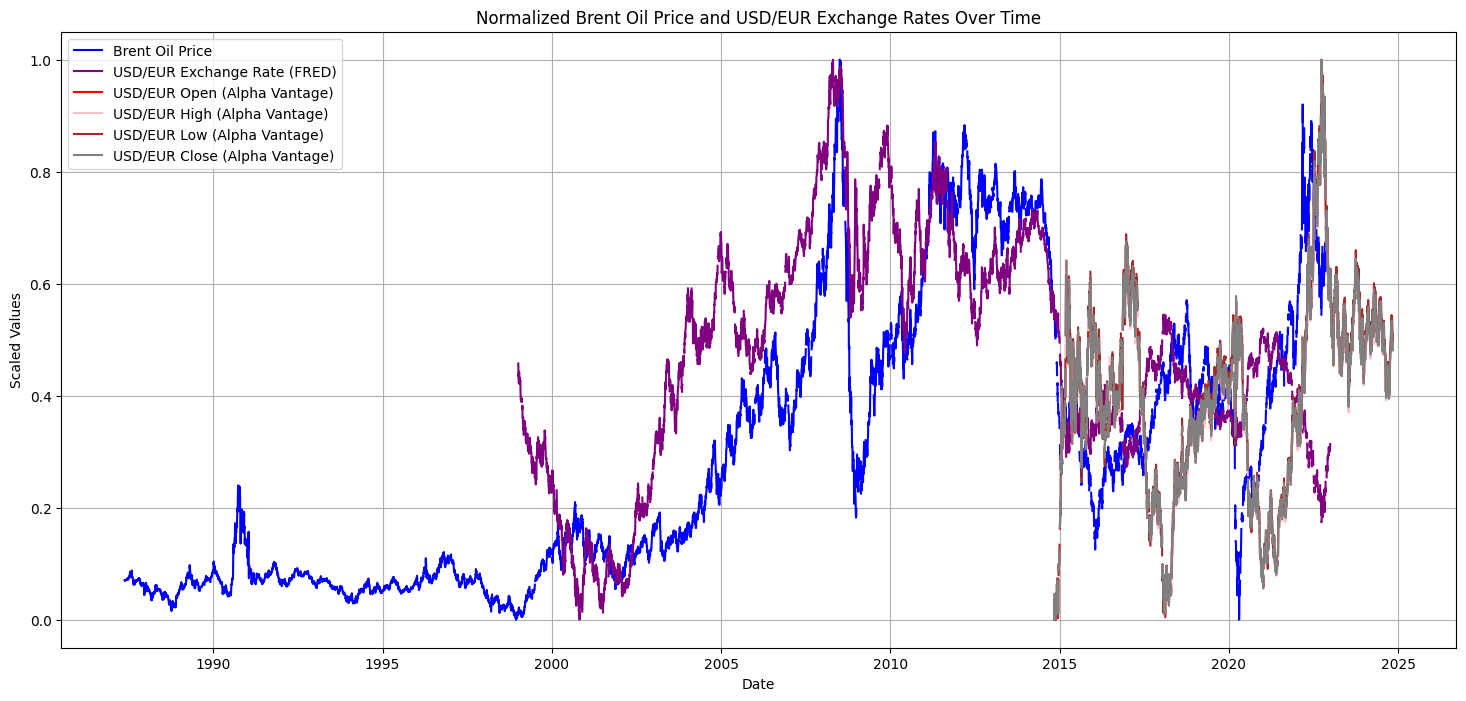

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler
scaler = MinMaxScaler()

# Apply Min-Max Scaling to relevant columns, ignoring the 'Date' column
columns_to_scale = ['Price', 'DEXUSEU', 'Open', 'High', 'Low', 'Close']
merged_data[columns_to_scale] = scaler.fit_transform(merged_data[columns_to_scale])

# Plotting
plt.figure(figsize=(18, 8))

# Plot each normalized column in a single plot with different colors and labels
plt.plot(merged_data['Date'], merged_data['Price'], label='Brent Oil Price', color='blue')
plt.plot(merged_data['Date'], merged_data['DEXUSEU'], label='USD/EUR Exchange Rate (FRED)', color='purple')
plt.plot(merged_data['Date'], merged_data['Open'], label='USD/EUR Open (Alpha Vantage)', color='red')
plt.plot(merged_data['Date'], merged_data['High'], label='USD/EUR High (Alpha Vantage)', color='pink')
plt.plot(merged_data['Date'], merged_data['Low'], label='USD/EUR Low (Alpha Vantage)', color='brown')
plt.plot(merged_data['Date'], merged_data['Close'], label='USD/EUR Close (Alpha Vantage)', color='gray')

# Labels and title
plt.xlabel('Date')
plt.ylabel('Scaled Values')
plt.title('Normalized Brent Oil Price and USD/EUR Exchange Rates Over Time')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()